# Context Vector Analysis
### **Objective**

This project aims to analyze **context vectors** within transformer-based models, focusing on their extraction and usage in NLP tasks. The key research questions include:

### **Research Questions**

1. **Where is the Context Vector in Transformer Models?**
    - Investigate where the **context vector** is located within transformer architectures.
    - Notably, **Sentence Transformers (SBERT)** do not explicitly extract context vectors, raising the need for a deeper analysis.
    - Explore how self-attention mechanisms, hidden states, and intermediate layers contribute to the formation of context vectors.
2. **Which Layer Produces the Best Context Vector?**
    - Determine whether the **final layer** or **earlier layers (2nd/3rd)** provide a more meaningful context representation.
    - In BERT-based models, the **last hidden state may be overly fine-tuned**, while **intermediate layers might capture more generalizable contextual information**.
    - Compare context vectors extracted from different layers to identify the optimal representation.
3. **How Do Context Vectors Function?**
    - Examine the role of context vectors in NLP downstream tasks such as **next-word prediction, sentence similarity, and text classification**.
    - Explore how these vectors influence decision-making in transformer models.

### **Additional Research Directions**

- **Locating the context vector** in Transformer-based LLMs (e.g., GPT, BERT, SBERT)
- **Comparing different embedding methods** (BERT vs. SBERT vs. GPT vs. Universal Sentence Encoder)
- **Evaluating the effectiveness** of context vectors in semantic representation
- **Developing criteria for selecting layers** to extract meaningful contextual representations

### **Key Takeaways**

- Identifying **where the context vector is formed** within a transformer model
- **Comparing different layers** to determine the most informative context vector
- Exploring **how context vectors impact various NLP tasks**

### Workflow Breakdown

1. Build a Model Pipeline using a Naive Language Model
  - Use BERT, RoBERTa, or another transformer-based model as the base encoder.
  - Tokenize input sentences and pass them through the model to obtain hidden states.

2. Extract Features from Different Layers
  - Extract final layer features (last hidden state)
  - Extract intermediate layer features (e.g., 2nd or 3rd layer hidden states).
	- Compare these feature representations in terms of their contextual richness.

3. Compare the Contextual Information in Both Vectors
	- Define evaluation criteria to assess which vector contains richer semantic information.
	- Test how well each vector performs in a downstream NLP task (e.g., sentence similarity, clustering, classification).

### Evaluation Matrix

To compare the richness of the extracted features, possible evaluation methods include:
1. Sentence Similarity Tasks: Compare vector representations using cosine similarity.
2. Clustering Evaluation: K-Means or hierarchical clustering to assess feature separability.
3. Linear Probing: Train a classifier on top of extracted features to test their predictive power.
4. Dimensionality Analysis: Use PCA or t-SNE to visualize feature distribution.

In [3]:
## Load Data
import json

filename = "/content/wikipedia_1000_sentences.json"
with open(filename, "r", encoding="utf-8") as f:
  sentences = json.load(f)

print(sentences)

['Anarchism is a political philosophy and movement that is skeptical of all justifications for authority and seeks to abolish the institutions it claims maintain unnecessary coercion and hierarchy, typically including nation-states, and capitalism.', 'Anarchism advocates for the replacement of the state with stateless societies and voluntary free associations.', 'As a historically left-wing movement, this reading of anarchism is placed on the farthest left of the political spectrum, usually described as the libertarian wing of the socialist movement (libertarian socialism).', 'Humans have lived in societies without formal hierarchies long before the establishment of states, realms, or empires.', 'With the rise of organised hierarchical bodies, scepticism toward authority also rose.', 'Although traces of anarchist ideas are found all throughout history, modern anarchism emerged from the Enlightenment.', "During the latter half of the 19th and the first decades of the 20th century, the a

In [4]:
## Load Bert Model and Tokenizer
import torch
from transformers import BertTokenizer, BertModel
import numpy as np
from scipy.spatial.distance import cosine

model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name, output_hidden_states=True)
model.eval()  # Evaluation mode

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

- bert-base-uncased: 12 layers

In [11]:
## define the function that extracts Features

def get_features(sentence, model, tokenizer, layer_indices=[-1, -4]):
    inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True, max_length=128)

    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)  # Ensure hidden states are returned

    hidden_states = outputs.hidden_states  # Extract all hidden states

    # Extract final layer embedding
    final_layer_emb = hidden_states[layer_indices[0]][:, 0, :].squeeze(0).cpu().numpy()

    # Extract intermediate layer embedding (e.g., -4th layer)
    intermediate_layer_emb = hidden_states[layer_indices[1]][:, 0, :].squeeze(0).cpu().numpy()

    return final_layer_emb, intermediate_layer_emb

In [13]:
## get features in the last layer and 2/3th layers
final_emb, inter_emb = get_features(sentences[0], model, tokenizer)

print("Final embedding shape:", final_emb.shape)
print("Intermediate embedding shape:", inter_emb.shape)

Final embedding shape: (768,)
Intermediate embedding shape: (768,)


In [14]:
batch_size = 32
num_batches = len(sentences) // batch_size + (len(sentences) % batch_size != 0)

final_embeddings = []
intermediate_embeddings = []

for i in range(num_batches):
    batch = sentences[i * batch_size: (i + 1) * batch_size]
    batch_final_emb, batch_inter_emb = get_features(batch, model, tokenizer)

    final_embeddings.append(batch_final_emb)
    intermediate_embeddings.append(batch_inter_emb)

final_embeddings = np.concatenate(final_embeddings, axis=0)
intermediate_embeddings = np.concatenate(intermediate_embeddings, axis=0)

print("Final embedding shape:", final_embeddings.shape)
print("Intermediate embedding shape:", intermediate_embeddings.shape)

Final embedding shape: (1000, 768)
Intermediate embedding shape: (1000, 768)


### evaluation

In [15]:
# Compute cosine similarity between final and intermediate embeddings
cosine_similarities = [1 - cosine(em1, em2) for em1, em2 in zip(final_embeddings, intermediate_embeddings)]

# Evaluate which embedding carries more contextual information
print(f"Average Cosine Similarity between Final and Intermediate Layer Embeddings: {np.mean(cosine_similarities):.4f}")

Average Cosine Similarity between Final and Intermediate Layer Embeddings: 0.5146


In [19]:
import numpy as np
import random
from sklearn.metrics.pairwise import cosine_similarity

# make sentence pair
num_pairs = 100
random.seed(42)
indices = list(range(len(final_embeddings)))
random.shuffle(indices)
sentence_pairs = [(final_embeddings[i], final_embeddings[j]) for i, j in zip(indices[:num_pairs], indices[num_pairs:2*num_pairs])]
intermediate_sentence_pairs = [(intermediate_embeddings[i], intermediate_embeddings[j]) for i, j in zip(indices[:num_pairs], indices[num_pairs:2*num_pairs])]

# Cosine Similarity
final_similarities = [cosine_similarity([s1], [s2])[0][0] for s1, s2 in sentence_pairs]
intermediate_similarities = [cosine_similarity([s1], [s2])[0][0] for s1, s2 in intermediate_sentence_pairs]

print(f"Mean Cosine Similarity (Final Layer): {np.mean(final_similarities):.4f}")
print(f"Mean Cosine Similarity (Intermediate Layer): {np.mean(intermediate_similarities):.4f}")

Mean Cosine Similarity (Final Layer): 0.7017
Mean Cosine Similarity (Intermediate Layer): 0.8264


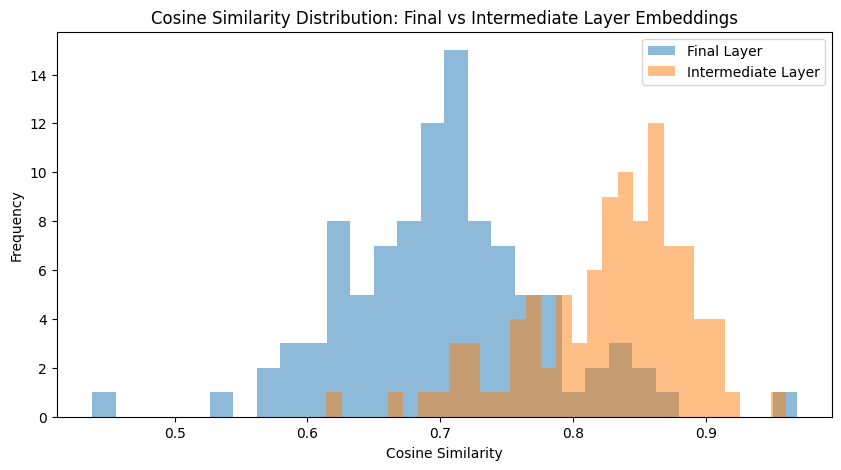

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.hist(final_similarities, alpha=0.5, label="Final Layer", bins=30)
plt.hist(intermediate_similarities, alpha=0.5, label="Intermediate Layer", bins=30)
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.legend()
plt.title("Cosine Similarity Distribution: Final vs Intermediate Layer Embeddings")
plt.show()


### Plot Analysis
1.	Final Layer (Blue) has a lower similarity on average
	- The cosine similarities of embeddings from the final layer are mostly between 0.6 and 0.75.
	- This suggests that the final layer captures more diverse representations, leading to greater variation between sentence embeddings.
2.	Intermediate Layer (Orange) has a higher similarity
	- The cosine similarities of embeddings from the intermediate layer are mostly between 0.75 and 0.9.
	- This indicates that the intermediate layer produces embeddings that are more tightly clustered, meaning they might retain more general contextual information.
3.	Final Layer might be more specialized
	-	The broader spread of cosine similarities suggests that the final layer’s representations are more specific to each sentence.
	- This aligns with the idea that higher transformer layers specialize more toward the specific task (e.g., masked token prediction for BERT).
4.	Intermediate Layer is more generalized
	- The higher similarities suggest that intermediate layers might retain richer contextual information that is less specialized but more general-purpose.

### Interpreataions
- 	If the goal is to obtain a rich contextual representation, the intermediate layer might be better, since it preserves more general meaning across different sentences.
- 	If the goal is to get task-specific representations, such as for classification or fine-tuning, the final layer might be more useful, as it encodes more specialized features.



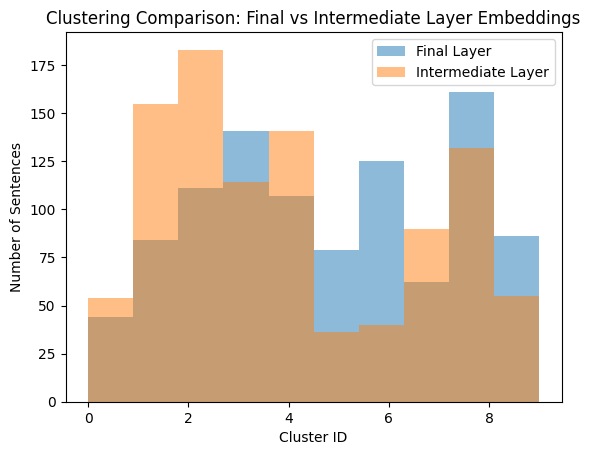

In [21]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Define number of clusters
num_clusters = 10

# Apply K-Means clustering to both sets of embeddings
kmeans_final = KMeans(n_clusters=num_clusters, random_state=42).fit(final_embeddings)
kmeans_intermediate = KMeans(n_clusters=num_clusters, random_state=42).fit(intermediate_embeddings)

# Compare cluster distributions
plt.hist(kmeans_final.labels_, alpha=0.5, label="Final Layer")
plt.hist(kmeans_intermediate.labels_, alpha=0.5, label="Intermediate Layer")
plt.xlabel("Cluster ID")
plt.ylabel("Number of Sentences")
plt.legend()
plt.title("Clustering Comparison: Final vs Intermediate Layer Embeddings")
plt.show()

### Observation
1.	More uniform clustering in the intermediate layer (Orange)
	- The intermediate layer embeddings seem to spread more evenly across clusters.
	- This suggests that the intermediate embeddings are more general and capture broader contextual information, leading to a balanced cluster distribution.
2.	Final layer embeddings (Blue) tend to concentrate in specific clusters
	- Some clusters contain more final-layer embeddings, while others have fewer.
	- This implies that final-layer embeddings are more specialized, possibly encoding more task-specific or fine-tuned information.
3.	Cluster membership differences
	- Some clusters have more intermediate embeddings than final-layer embeddings, while others show the opposite trend.
	- This might indicate that final-layer representations differentiate sentences in a finer-grained way, while intermediate layers capture higher-level similarities.

### Anlaysis
- Intermediate Layer: More general-purpose representations: Intermediate layer embeddings group sentences into broader, more balanced clusters. This suggests they might be more useful for general semantic similarity tasks.
- Final Layer: More specialized sentence representations: The final-layer embeddings tend to concentrate in specific clusters, meaning they may focus on specific features learned during pretraining. This aligns with the idea that final-layer representations are more suited for task-specific fine-tuning.